## Business Problem

## My Comprehension
[What is Computer Vision?](https://www.youtube.com/watch?v=-4E2-0sxVUM)

[Medium Article](https://asagar60.medium.com/tablenet-deep-learning-model-for-end-to-end-table-detection-and-tabular-data-extraction-from-b1547799fe29) used as Guide for [TableNet](https://arxiv.org/pdf/2001.01469.pdf)

Segmentation: [What is Semantic Segmentation?](https://www.youtube.com/watch?v=5QUmlXBb0MY)

[what are Masks and Contours in Computer Vision?](https://www.google.com/search?q=what+are+masks+and+contours+computer+vision&oq=what+are+masks+and+contours+computer+vision&gs_lcrp=EgZjaHJvbWUyBggAEEUYOdIBCDM4ODhqMGo0qAIAsAIA&sourceid=chrome&ie=UTF-8)

### 1. Description

With the increase use of mobile devices, customers tend to share documents as images rather than scanning them. These images are later processed manually to get important information stored in Tables. These tables can be of different sizes and structures. It is therefore expensive to get information in Tables from images. 

With TableNet we will employ and end-to-end Deep learning architecture which will not only localize the Table in an image, but will also generate structure of Table by segmenting columns in that Table.


### 2. Problem Statement 

-	The objective is to localize / detect a Table (if present) and its structure in an Image 
-   If Table and its columns are detected, then extract the data using OCR.


### 3. Business Constraints

- Model should detect/ localize Tables and columns with high accuracy. 
- No strict latency requirement

## Data

We will use both Original Marmot and Extended Marmot dataset for this case study.

Extended Marmot dataset only contains column bounding box coordinates, for this reason we will also use original Marmot Dataset to get table bounding box coordinates as well.

Marmot Extended dataset for Table Recognition. The data is open-sourced by authors of this paper.

For this self-case study, we will only use English pages from the dataset.

Source of data : https://drive.google.com/drive/folders/1QZiv5RKe3xlOBdTzuTVuYRxixemVIODp

## DL problem

This task will be dealt using semantic segmentation by predicting pixel-wise regions of Table and columns in them

### Performance Metric

Accuracy and F1 Score – we will use both accuracy and F1 Score to take both precision and recall into account, so that False Positives and False Negatives can be reduced. 

In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
#import libraries

import os
import math
import cv2
import struct
import glob
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import xml.etree.ElementTree as ET

In [3]:
#Data paths

ORIG_DATA_PATH = "./marmot/marmot_dataset_v1.0/data/English"
POSITIVE_DATA_LBL = os.path.join(ORIG_DATA_PATH, 'Positive','Labeled')
# DATA_PATH = 'Marmot_data'
DATA_PATH = './marmot/Marmot_data'
PROCESSED_DATA = 'marmot_processed'
IMAGE_PATH = os.path.join(PROCESSED_DATA, 'image')
TABLE_MASK_PATH = os.path.join(PROCESSED_DATA, 'table_mask')
COL_MASK_PATH = os.path.join(PROCESSED_DATA, 'col_mask')
COL_MASK_PATH_NEW = os.path.join(PROCESSED_DATA, 'col_mask_new')

In [4]:
#utility functions

# Extract Image coordinate from Marmot dataset
# https://stackoverflow.com/a/58521586

def get_table_bbox(table_xml_path,  new_image_shape):
    
    """
    - Extract Table Coordinates from xml
    - Scale them w.r.t to new image shape
    
    Input:
        table_xml_path: str - xml path
        new_image_shape: tuple - (new_h, new_w)
    
    Output:
        table_bboxes: List 
    """

    tree = ET.parse(table_xml_path)
    root = tree.getroot()

    px0, py1, px1, py0 = list(map(lambda x: struct.unpack('!d', bytes.fromhex(x))[0], root.get("CropBox").split()))
    pw = abs(px1 - px0)
    ph = abs(py1 - py0)

    table_bboxes = []

    for table in root.findall(".//Composite[@Label='TableBody']"):
        x0p, y0m, x1p,y1m  = list(map(lambda x: struct.unpack('!d', bytes.fromhex(x))[0], table.get("BBox").split()))
        x0 = round(new_image_shape[1]*(x0p - px0)/pw)
        x1 = round(new_image_shape[1]*(x1p - px0)/pw)
        y0 = round(new_image_shape[0]*(py1 - y0m)/ph)
        y1 = round(new_image_shape[0]*(py1 - y1m)/ph)
        
        table_bboxes.append([x0,y0, x1,y1])
    return table_bboxes


def get_col_bbox(column_xml_path, prev_img_shape, new_image_shape, table_bboxes):
    
    """
    - Extract Column Coordinates from xml
    - Scale them w.r.t to new image shape and prev image shape
    - If there are no table_bboxes present , approximate them using column bbox
    
    Input:
        table_xml_path: str - xml path
        prev_img_shape: tuple - (new_h, new_w)
        new_image_shape: tuple - (new_h, new_w)
        table_bboxes: List - list of table bbox coordinates
    
    Output:
        table_bboxes: List 
    """
    
    tree = ET.parse(column_xml_path)
    root = tree.getroot()
    xmins = [round(int(coord.text) * new_image_shape[1] / prev_img_shape[1]) for coord in root.findall("./object/bndbox/xmin")]
    xmaxs = [round(int(coord.text) * new_image_shape[1] / prev_img_shape[1]) for coord in root.findall("./object/bndbox/xmax")]
    ymins = [round(int(coord.text) * new_image_shape[0] / prev_img_shape[0]) for coord in root.findall("./object/bndbox/ymin")]
    ymaxs = [round(int(coord.text) * new_image_shape[0] / prev_img_shape[0]) for coord in root.findall("./object/bndbox/ymax")]

    col_bbox = []
    for x_min, y_min, x_max, y_max in zip(xmins,ymins,xmaxs,ymaxs):
        bbox = [x_min, y_min, x_max, y_max]
        col_bbox.append(bbox)
    
    #fix 1: if no table coord but have column coord
    if len(table_bboxes) == 0:
        thresh = 3
        x_min = min([x[0] for x in col_bbox]) - thresh 
        y_min = min([x[1] for x in col_bbox]) - thresh 
        x_max = max([x[2] for x in col_bbox]) + thresh  
        y_max = max([x[3] for x in col_bbox]) + thresh 
        
        table_bboxes = [[x_min, y_min, x_max, y_max]]
    
    return col_bbox, table_bboxes

def create_mask(new_h, new_w, bboxes = None):
    
    """
    - create a mask based on new_h, new_w and bounding boxes
    
    Input:
        new_h: int - height of the mask
        new_w: int - width of the mask
        bboxes: List - bounding box coordinates  
    
    Output:
        mask: Image 
    """
    
    mask = np.zeros((new_h, new_w), dtype=np.int32)
    
    if bboxes is None or len(bboxes)==0:
         return Image.fromarray(mask)
    
    for box in bboxes:
        mask[box[1]:box[3], box[0]:box[2]] = 255
    
    return Image.fromarray(mask)

# EDA

## Marmot Dataset

We will be using data in terms of

- Positive Samples : Images with table in them
- Negative Samples : Images with no table in them

In [5]:
pos_data = glob.glob('./marmot/marmot_dataset_v1.0/data/English/Positive/Raw' + '/*.bmp')
neg_data = glob.glob('./marmot/marmot_dataset_v1.0/data/English/Negative/Raw' + '/*.bmp')

In [ ]:
pos_data

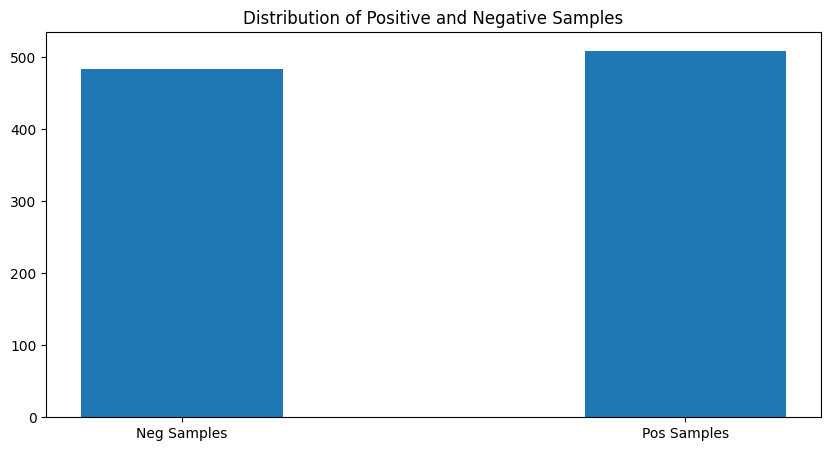

In [6]:
fig = plt.figure(figsize = (10, 5))

x = ['Neg Samples', 'Pos Samples']
y = [len(neg_data), len(pos_data)]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Positive and Negative Samples')
plt.show()

#### Observations:
- It is clear that there is no data imbalance problem

### 1. Negative sample will not contain any Table

In [7]:
new_h, new_w = 1024, 1024

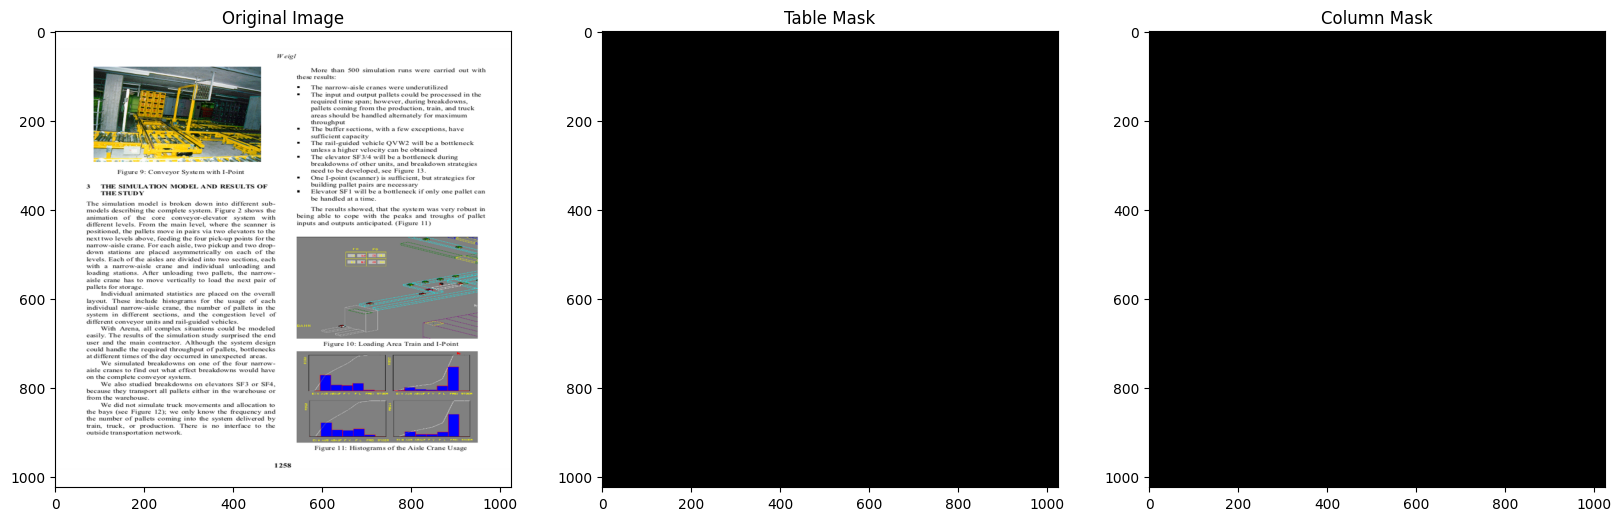

In [8]:
#Negative example - 1

img_path = './marmot/marmot_dataset_v1.0/data/English\\Negative\\Raw\\10.1.1.1.2000_4.bmp'
image = Image.open(img_path)

#resize image 1024, 1024
image = image.resize((new_h, new_w))

table_mask = create_mask(new_h, new_w)
col_mask = create_mask(new_h, new_w)


f, ax = plt.subplots(1,3, figsize = (20,15))

ax[0].imshow(np.array(image))
ax[0].set_title('Original Image')
ax[1].imshow(table_mask)
ax[1].set_title('Table Mask')
ax[2].imshow(col_mask)
ax[2].set_title('Column Mask')
plt.show()

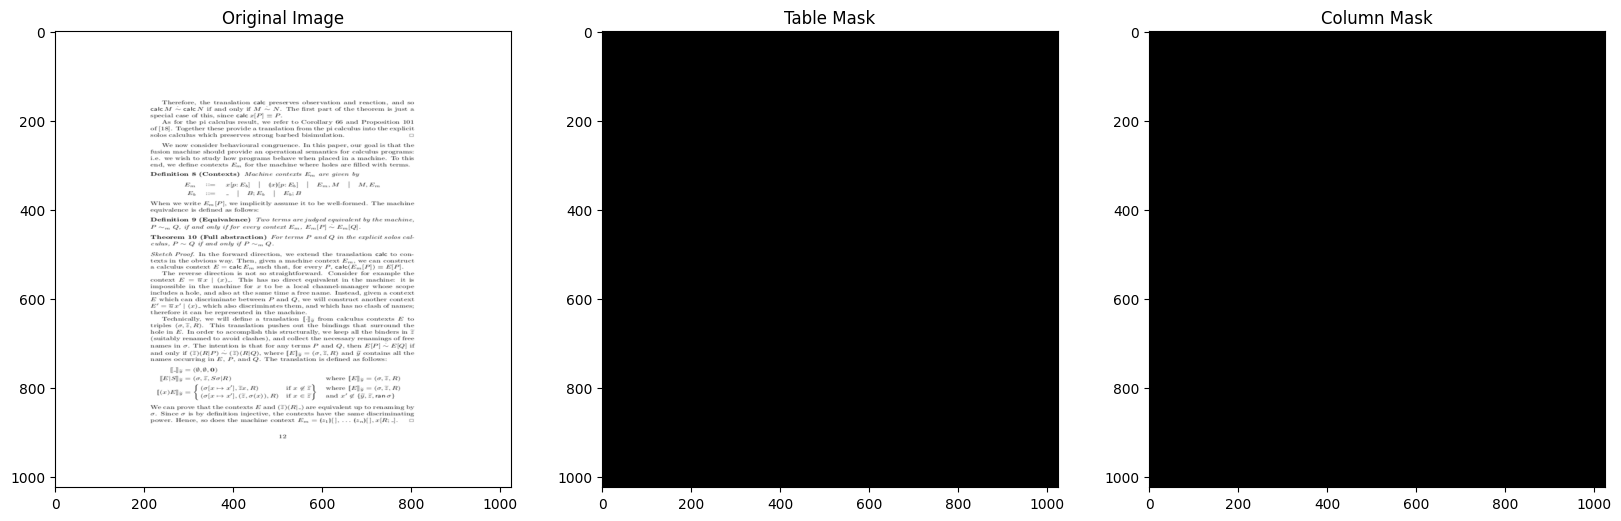

In [9]:
#Negative example - 2

img_path = './marmot/marmot_dataset_v1.0/data/English\\Negative\\Raw\\10.1.1.1.2016_12.bmp'
image = Image.open(img_path)

#resize imageto std 1024, 1024
image = image.resize((new_h, new_w))

table_mask = create_mask(new_h, new_w)
col_mask = create_mask(new_h, new_w)


f, ax = plt.subplots(1,3, figsize = (20,15))

ax[0].imshow(np.array(image))
ax[0].set_title('Original Image')
ax[1].imshow(table_mask)
ax[1].set_title('Table Mask')
ax[2].imshow(col_mask)
ax[2].set_title('Column Mask')
plt.show()

- There are figures which looks like tables but are not,
- Trained model should be able to differentiate between them

### 2. Positive Sample

In [10]:
#positive example

img_path = './marmot/marmot_dataset_v1.0/data/English/Positive/Raw/10.1.1.1.2006_3.bmp'
table_xml_path = './marmot/marmot_dataset_v1.0/data/English/Positive/Labeled/10.1.1.1.2006_3.xml'
column_xml_path = './marmot/Marmot_data/10.1.1.1.2006_3.xml'

In [11]:
#load image
image = Image.open(img_path)

#resize imageto std 1024, 1024
w, h = image.size
image = image.resize((new_h, new_w))

#convert to 3 channel image if 1 channel
if image.mode != 'RGB':
    image = image.convert("RGB")

#scaled versions of bbox coordinates of table
table_bboxes = get_table_bbox(table_xml_path, (new_h, new_w))

#scaled versions of bbox coordinates of columns
col_bboxes, table_bboxes = get_col_bbox(column_xml_path, (h,w), (new_h, new_w), table_bboxes)

In [ ]:
col_bboxes

In [ ]:
table_bboxes

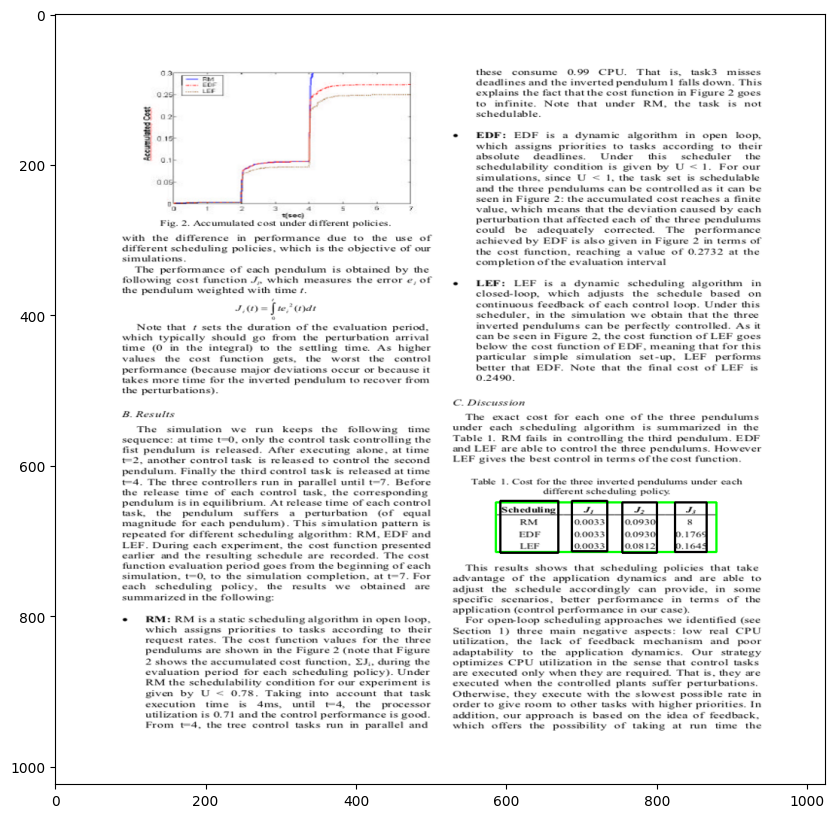

In [12]:
plt.figure(figsize = (20,10))

image_temp = np.array(image).copy()
for bbox in table_bboxes:
    cv2.rectangle(image_temp, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

for bbox in col_bboxes:
    cv2.rectangle(image_temp, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 0), 2)
    
plt.imshow(image_temp)

In [13]:
table_mask = create_mask(new_h, new_w, table_bboxes)
col_mask = create_mask(new_h, new_w, col_bboxes)

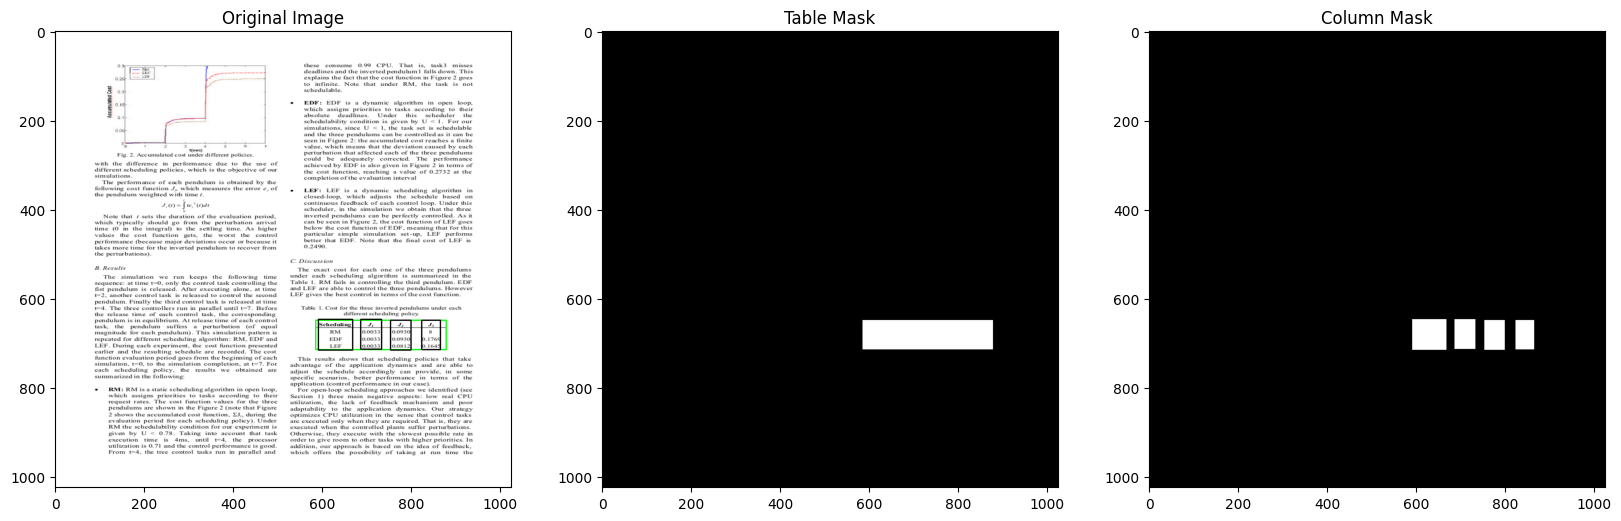

In [14]:
f, ax = plt.subplots(1,3, figsize = (20,15))

ax[0].imshow(np.array(image_temp))
ax[0].set_title('Original Image')
ax[1].imshow(table_mask)
ax[1].set_title('Table Mask')
ax[2].imshow(col_mask)
ax[2].set_title('Column Mask')
plt.show()

In [15]:
#positive example -2

img_path = './marmot/marmot_dataset_v1.0/data/English/Positive/Raw/10.1.1.8.2182_6.bmp'
table_xml_path = './marmot/marmot_dataset_v1.0/data/English/Positive/Labeled/10.1.1.8.2182_6.xml'
column_xml_path = './marmot/Marmot_data/10.1.1.8.2182_6.xml'

In [16]:
#load image
image = Image.open(img_path)

#resize imageto std 1024, 1024
w, h = image.size
image = image.resize((new_h, new_w))

#convert to 3 channel image if 1 channel
if image.mode != 'RGB':
    image = image.convert("RGB")

#scaled versions of bbox coordinates of table
table_bboxes = get_table_bbox(table_xml_path, (new_h, new_w))

In [ ]:
table_bboxes

No table bounding box for this image from orginal Marmot dataset, we will approximate it using Column Bounding Box

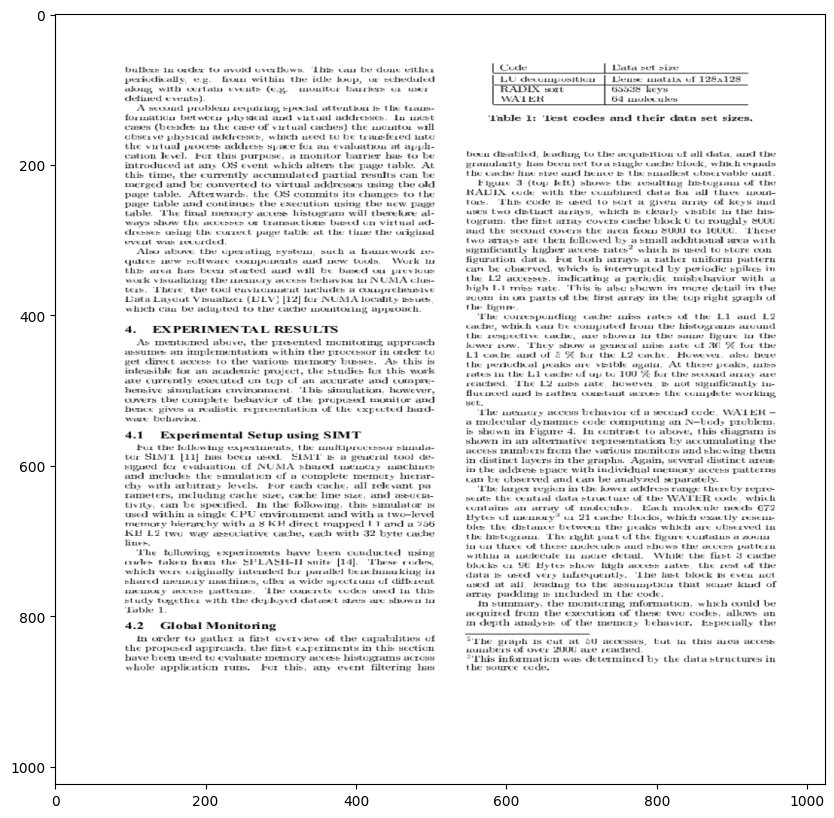

In [17]:
plt.figure(figsize = (20,10))
plt.imshow(np.array(image))
plt.show()

- We can see that the table is partially visible 
- and for this positive sample, original dataset has no table coordinates
- Since there are column coordinates present in extended version of this dataset, we will use column coordinates to get table coordinates

In [18]:
#scaled versions of bbox coordinates of columns
col_bboxes, table_bboxes = get_col_bbox(column_xml_path, (h,w), (new_h, new_w), table_bboxes)

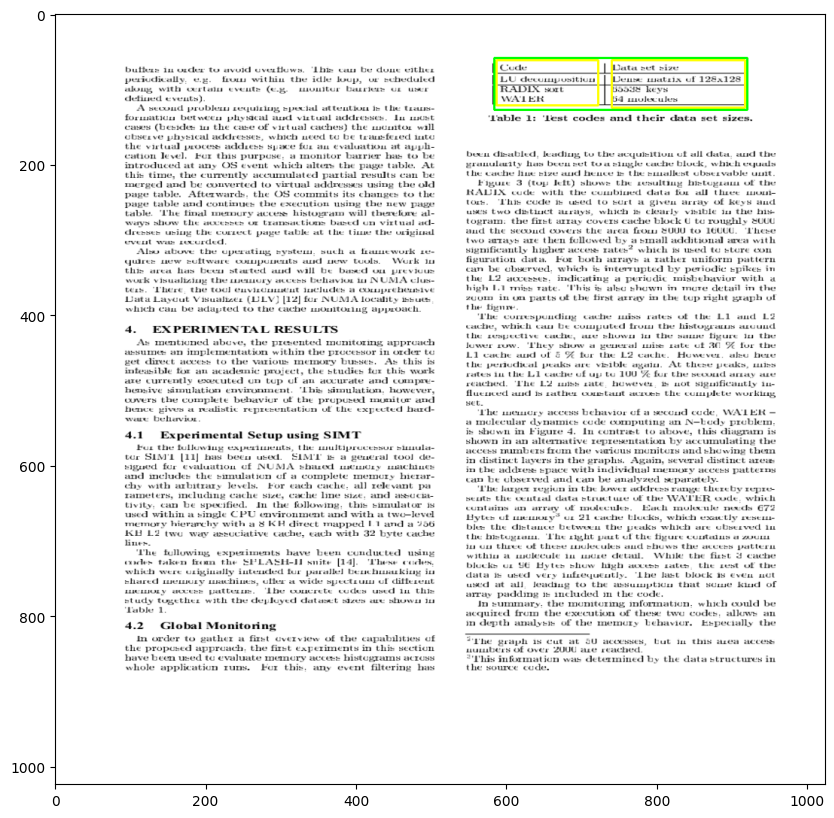

In [19]:
plt.figure(figsize = (20,10))

image_temp = np.array(image).copy()
for bbox in table_bboxes:
    cv2.rectangle(image_temp, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

for bbox in col_bboxes:
    cv2.rectangle(image_temp, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 0), 2)
    
plt.imshow(image_temp)

In [20]:
table_mask = create_mask(new_h, new_w, table_bboxes)
col_mask = create_mask(new_h, new_w, col_bboxes)

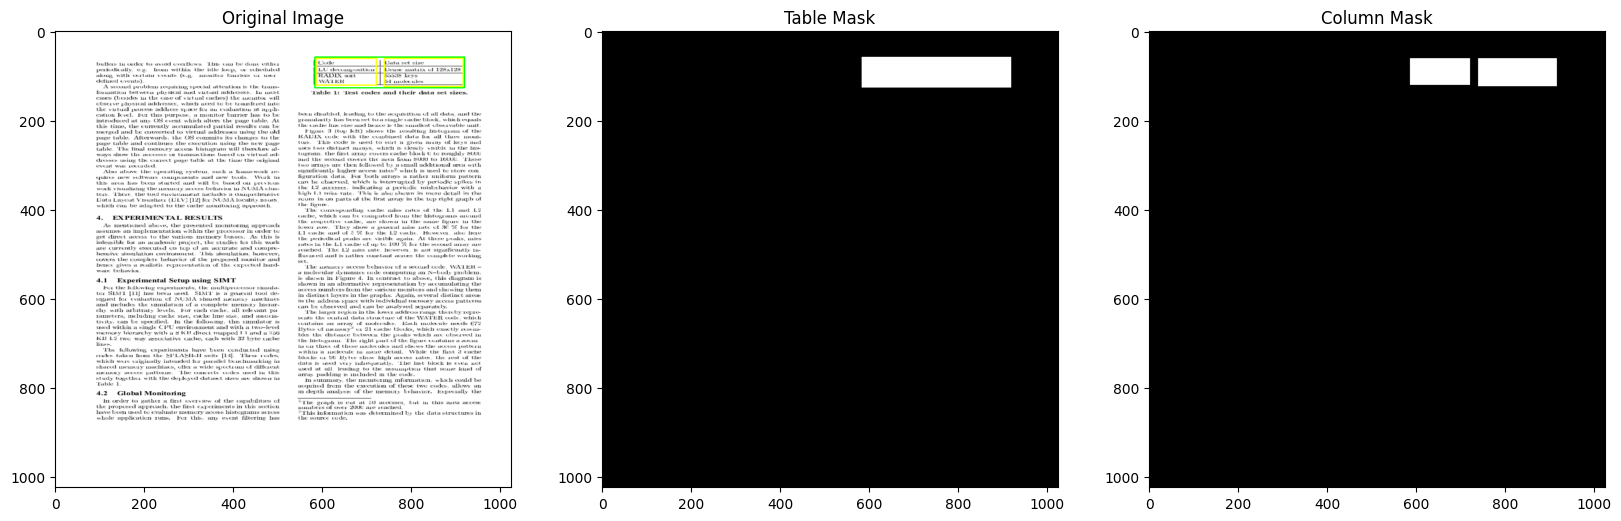

In [21]:
f, ax = plt.subplots(1,3, figsize = (20,15))

ax[0].imshow(np.array(image_temp))
ax[0].set_title('Original Image')
ax[1].imshow(table_mask)
ax[1].set_title('Table Mask')
ax[2].imshow(col_mask)
ax[2].set_title('Column Mask')
plt.show()

### Observations

- There are many figures in the images which looks like tables but are not,
- Model should be able to differentiate between them
- For Negative Samples , we will have masks with no activated pixels
- There are images with no predefined table bounding box coordinates from original dataset, but has column bounding box coordinates from extended version of the dataset.
- In such cases we will use column coordinates to approximate Table coordinates. 


## Data Preprocessing

In [65]:
#make directories to save data

os.makedirs(PROCESSED_DATA, exist_ok = True)
os.makedirs(IMAGE_PATH, exist_ok = True)
os.makedirs(TABLE_MASK_PATH, exist_ok = True)
os.makedirs(COL_MASK_PATH, exist_ok = True)

In [66]:
new_h, new_w = 1024, 1024

In [68]:
processed_data = []

for i, data in enumerate([pos_data, neg_data]):
# for i, data in enumerate([pos_data]):
    
    for j, img_path in tqdm(enumerate(data)):
        
        image_name = os.path.basename(img_path)
        image = Image.open(img_path)
        w, h = image.size
        
        #convert to RGB image
        image = image.resize((new_h, new_w))
        if image.mode != 'RGB':
            image = image.convert("RGB")
        table_bboxes, col_bboxes = [], []
        
        if i == 0:
        # if i == 0:
            
            #get xml filename
            xml_file = image_name.replace('bmp', 'xml')
            table_xml_path = os.path.join(POSITIVE_DATA_LBL, xml_file)
            column_xml_path = os.path.join(DATA_PATH,xml_file)
            
            #get table boxes
            table_bboxes = get_table_bbox(table_xml_path, (new_h, new_w))
            # print("column Path: ", column_xml_path)
            # print("Table Path: ", table_xml_path)
            #get column boxes , if table boxes are empty, approximate them using column boxes
            if os.path.exists(column_xml_path):
                col_bboxes, table_bboxes = get_col_bbox(column_xml_path, (h,w), (new_h, new_w), table_bboxes)
                # print("col_bboxes: ", col_bboxes)
            else:
                # print("In else")
                col_bboxes = []
            
        #generate masks
        table_mask = create_mask(new_h, new_w, table_bboxes)
        # col_mask = create_mask(new_h, new_w, [[110, 202, 220, 344], [271, 202, 291, 343], [305, 201, 419, 344]])
        col_mask = create_mask(new_h, new_w, col_bboxes)
        # print("test: ", type( [[110, 202, 220, 344], [271, 202, 291, 343], [305, 201, 419, 344]]))
        # image = cv2.imread(col_mask)
        # cv2.imshow(col_mask, image)
        # plt.imshow(col_mask) 
        # print(type(table_mask))
        # plt.imshow(table_mask) 
    
        #save images and masks
        if col_mask.mode != 'RGB':
            col_mask = col_mask.convert('RGB')
        if table_mask.mode != 'RGB':
            table_mask = table_mask.convert('RGB')
        save_image_path = os.path.join(IMAGE_PATH, image_name.replace('bmp', 'jpg'))
        save_table_mask_path = os.path.join(TABLE_MASK_PATH, image_name[:-4] + '_table_mask.png')
        save_col_mask_path = os.path.join(COL_MASK_PATH, image_name[:-4] + '_col_mask.png')
        # save_image_path = os.path.join("./Trail", image_name.replace('bmp', 'jpg'))
        # save_table_mask_path = os.path.join("./Trail", image_name[:-4] + '_table_mask.png')
        # save_col_mask_path = os.path.join("./Trail", image_name[:-4] + '_col_mask.png')
        
        image.save(save_image_path)
        table_mask.save(save_table_mask_path)
        col_mask.save(save_col_mask_path)
        
        #add data to dataframe
        len_table = len(table_bboxes)
        len_cols = len(col_bboxes)

        value = (save_image_path, save_table_mask_path, save_col_mask_path, h, w, int(len_table != 0), \
                 len_table, len_cols, table_bboxes, col_bboxes)
        
        processed_data.append(value)
        
        # if j == 10:
            # break
    # if i == 4:
        # break

509it [05:57,  1.42it/s]
484it [05:21,  1.51it/s]


In [69]:

column_name = ['img_path','table_mask','col_mask','original_height','original_width','hasTable','table_count','col_count','table_bboxes','col_bboxes']
processed_data = pd.DataFrame(processed_data, columns=column_name)

In [74]:
processed_data.to_csv("processed_data.csv", index = False)

In [75]:
processed_data.head()

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
0,marmot_processed\image\10.1.1.1.2000_4.jpg,marmot_processed\table_mask\10.1.1.1.2000_4_ta...,marmot_processed\col_mask\10.1.1.1.2000_4_col_...,1008,768,0,0,0,[],[]
1,marmot_processed\image\10.1.1.1.2004_4.jpg,marmot_processed\table_mask\10.1.1.1.2004_4_ta...,marmot_processed\col_mask\10.1.1.1.2004_4_col_...,1123,793,0,0,0,[],[]
2,marmot_processed\image\10.1.1.1.2004_5.jpg,marmot_processed\table_mask\10.1.1.1.2004_5_ta...,marmot_processed\col_mask\10.1.1.1.2004_5_col_...,1123,793,0,0,0,[],[]
3,marmot_processed\image\10.1.1.1.2005_12.jpg,marmot_processed\table_mask\10.1.1.1.2005_12_t...,marmot_processed\col_mask\10.1.1.1.2005_12_col...,1056,816,0,0,0,[],[]
4,marmot_processed\image\10.1.1.1.2005_13.jpg,marmot_processed\table_mask\10.1.1.1.2005_13_t...,marmot_processed\col_mask\10.1.1.1.2005_13_col...,1056,816,0,0,0,[],[]


In [76]:
processed_data = pd.read_csv('processed_data.csv')

In [77]:
processed_data.head()

,img_path,table_mask,col_mask,original_height,original_width,hasTable,table_count,col_count,table_bboxes,col_bboxes
0,marmot_processed\image\10.1.1.1.2000_4.jpg,marmot_processed\table_mask\10.1.1.1.2000_4_ta...,marmot_processed\col_mask\10.1.1.1.2000_4_col_...,1008,768,0,0,0,[],[]
1,marmot_processed\image\10.1.1.1.2004_4.jpg,marmot_processed\table_mask\10.1.1.1.2004_4_ta...,marmot_processed\col_mask\10.1.1.1.2004_4_col_...,1123,793,0,0,0,[],[]
2,marmot_processed\image\10.1.1.1.2004_5.jpg,marmot_processed\table_mask\10.1.1.1.2004_5_ta...,marmot_processed\col_mask\10.1.1.1.2004_5_col_...,1123,793,0,0,0,[],[]
3,marmot_processed\image\10.1.1.1.2005_12.jpg,marmot_processed\table_mask\10.1.1.1.2005_12_t...,marmot_processed\col_mask\10.1.1.1.2005_12_col...,1056,816,0,0,0,[],[]
4,marmot_processed\image\10.1.1.1.2005_13.jpg,marmot_processed\table_mask\10.1.1.1.2005_13_t...,marmot_processed\col_mask\10.1.1.1.2005_13_col...,1056,816,0,0,0,[],[]


## Advanced EDA

In [ ]:
processed_data['hasTable'].value_counts().tolist()

#### Positive : Negative Ratio

In [ ]:
fig = plt.figure(figsize = (10, 5))

x = ['Neg Samples', 'Pos Samples']
data = processed_data['hasTable'].value_counts().tolist()
y = [data[1],data[0]]
plt.bar(x, y,width = 0.4)
plt.title('Distribution of Positive and Negative Samples')
plt.show()

#### Columns without any Table

In [ ]:
processed_data[(processed_data['table_count']==0)]

#### Table with No Columns

In [ ]:
processed_data[(processed_data['hasTable']==1) & (processed_data['col_count']==0)]

#### plotting image with table but no columns

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.1.2010_5.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.1.2107_9.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.160.669_3.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.7.2174_3.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
image = plt.imread('marmot_processed/image/10.1.1.7.2174_8.jpg')
plt.imshow(image)
plt.title('Table with No columns')
plt.show()

### Observations

- There are 5 images with tables but no columns
- There are total 494 Negative Samples and 499 Positive Samples.
- Also, we confirmed that there are no columns with only tables.

### Height of the Image

In [ ]:
processed_data['original_height'].plot.hist(bins = 10)

In [ ]:
sns.kdeplot(processed_data['original_height'], color='b', fill=True)
  
plt.xlabel('Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Image

In [ ]:
processed_data['original_width'].plot.hist(bins = 10)

In [ ]:
sns.kdeplot(processed_data['original_width'], color='b', fill=True)

plt.xlabel('Width')
plt.ylabel('Probability Density')
plt.show()

### Total Tables

In [ ]:
processed_data['table_count'].value_counts().plot.bar()
plt.xlabel('Tables')
plt.ylabel('Count')
plt.show()

### Total Columns

In [ ]:
processed_data['col_count'].value_counts().plot.bar()
plt.xlabel('Columns')
plt.ylabel('Count')
plt.show()

In [ ]:
import json


### Observations

- Height of most images are between 1000 - 1100
- Width of most images are between 700-800.
- Apart from images with no Tables, most images contains only 1 table and at maximum 4 tables.
- Total Columns in an image (can have multiple tables in a page) ranges from 4 - 42
- We have also seen Image with no columns but have Tables in them.

### Height of Table

In [ ]:
heights = []
widths = []
for boxes in processed_data[processed_data['hasTable']==1]['table_bboxes']:
    # boxes = [json.loads('[' + boxes.strip('][').strip(',') + ']')]
    print(boxes)
# Convert the cleaned string to a Python list
# array = json.loads('[' + cleaned_string + ']')
    # for box in boxes:
    #     heights.append(box[3]-box[1])
    #     widths.append(box[2]-box[0])

In [ ]:
min(col_widths)

In [ ]:
sns.histplot(heights, color='b', Label='Table Height')

plt.xlabel('Table Height')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(heights, color='b', shade=True, Label='Table Height')

plt.xlabel('Table Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Table

In [ ]:
sns.histplot(widths, color='b', Label='Table Width')

plt.xlabel('Table Width')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(widths, color='b', shade=True, Label='Table Width')

plt.xlabel('Table Width')
plt.ylabel('Probability Density')
plt.show()

### Height of the Column

In [ ]:
col_heights = []
col_widths = []
for boxes in processed_data[processed_data['hasTable']==1]['col_bboxes']:
    for box in boxes:
        col_heights.append(box[3]-box[1])
        col_widths.append(box[2]-box[0])

In [ ]:
sns.histplot(col_heights, color='b', Label='Column Height')

plt.xlabel('Column Height')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(col_heights, color='b', shade=True, Label='Column Height')

plt.xlabel('Column Height')
plt.ylabel('Probability Density')
plt.show()

### Width of the Column

In [ ]:
sns.histplot(col_widths, color='b', Label='Column Width')

plt.xlabel('Column Width')
plt.ylabel('Counts')
plt.show()

In [ ]:
sns.kdeplot(col_widths, color='b', shade=True, Label='Table Column')

plt.xlabel('Table Column')
plt.ylabel('Probability Density')
plt.show()

### Observations

- Height of tables ranges from 30 - 870, but most are between  50-300.
- Width of tables ranges from 50 - 900, but common width is 400.
- Height of columns ranges from 10 - 880 showing a right skewed distribution
- Width of columns ranges from 7 - 671 showing a right skewed distribution